In [3]:
# imports & config
import time, joblib, math
import numpy as np, pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


# Sampling & search configuration (tune these to control runtime)
USE_SAMPLE_FOR_SEARCH = True         # True = run RandomizedSearch on a sample (recommended)
SAMPLE_SIZE = 200_000                # number of training rows used for hyperparam search (adjust)
N_ITER = 8                           # number of RandomizedSearch candidates (lower -> faster)
CV_FOLDS = 3                         # CV folds for RandomizedSearch (3 is reasonable)
SCORING = "f1_macro"                 # robust to class imbalance
RANDOM_STATE = 42

# Final model training config
FINAL_TRAIN_ON_FULL = True           # after search, train final model on full training data
PROJECT_PATH = '/content/drive/My Drive/Datasets/ML Project/data/recommended'
TRAIN_PATH = f"{PROJECT_PATH}/training/training_cleaned.csv"
TEST_PATH  = f"{PROJECT_PATH}/test/test_cleaned.csv"

# ------------------------------------------------------
print("Config -> SAMPLE_SIZE:", SAMPLE_SIZE, "N_ITER:", N_ITER, "CV_FOLDS:", CV_FOLDS)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Config -> SAMPLE_SIZE: 200000 N_ITER: 8 CV_FOLDS: 3


In [4]:
#load data
train_df = pd.read_csv(TRAIN_PATH, low_memory=False)
test_df  = pd.read_csv(TEST_PATH, low_memory=False)

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)
print("\nTrain columns:\n", train_df.columns.tolist())
print("\nTest columns:\n", test_df.columns.tolist())


Train shape: (2934817, 14)
Test shape:  (733705, 14)

Train columns:
 ['pkSeqID', 'min', 'max', 'mean', 'stddev', 'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'sport', 'dport', 'proto', 'state_number', 'category']

Test columns:
 ['pkSeqID', 'min', 'max', 'mean', 'stddev', 'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'sport', 'dport', 'proto', 'state_number', 'category']


In [5]:
# create target (category only)
train_df["Target"] = train_df["category"].astype(str)
test_df["Target"]  = test_df["category"].astype(str)

print("Unique train categories:", train_df["Target"].nunique())
print("Unique test categories: ", test_df["Target"].nunique())


Unique train categories: 8
Unique test categories:  8


In [6]:
# select categorical feature columns present in your data
feature_cat_cols = [c for c in ["sport","dport","proto"] if c in train_df.columns and c in test_df.columns]
print("Categorical feature cols:", feature_cat_cols)

from sklearn.preprocessing import OrdinalEncoder
MODEL_PATH = '/content/drive/My Drive/Datasets/ML Project/models/without'
encoder_path = f"{MODEL_PATH}/random_forest_encoder.joblib"

# encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
encoder = joblib.load(encoder_path)

# Fit encoder on train (string-cast to be safe), transform train and test
train_df[feature_cat_cols] = encoder.fit_transform(train_df[feature_cat_cols].astype(str))
test_df[feature_cat_cols]  = encoder.transform(test_df[feature_cat_cols].astype(str))

# Save encoder into a dict for later saving
encoders = {"feature_encoder": encoder}


Categorical feature cols: ['sport', 'dport', 'proto']


In [7]:
#map target to ints based on training set only
unique_targets = train_df["Target"].unique().tolist()
target_to_int = {'DDoS UDP': 0, 'DDoS TCP': 1, 'DoS UDP': 2, 'DoS TCP': 3, 'Reconnaissance OS_Fingerprint': 4, 'Reconnaissance Service_Scan': 5, 'Normal': 6, 'Theft': 7}
print(target_to_int)
int_to_target = {i: t for t, i in target_to_int.items()}

train_df["Target_int"] = train_df["Target"].map(target_to_int)
test_df["Target_int"]  = test_df["Target"].map(lambda x: target_to_int.get(x, -1))  # unseen -> -1

n_unseen = (test_df["Target_int"] == -1).sum()
print("Train unique classes:", len(unique_targets))
print("Test rows with unseen classes (will be excluded):", n_unseen)
if n_unseen > 0:
    print("Examples of unseen test classes (first 10):", test_df.loc[test_df["Target_int"]==-1, "Target"].unique()[:10])


{'DDoS UDP': 0, 'DDoS TCP': 1, 'DoS UDP': 2, 'DoS TCP': 3, 'Reconnaissance OS_Fingerprint': 4, 'Reconnaissance Service_Scan': 5, 'Normal': 6, 'Theft': 7}
Train unique classes: 8
Test rows with unseen classes (will be excluded): 0


In [8]:
#  prepare X/y, drop columns that would leak or are not features
cols_to_drop = [c for c in ["pkSeqID","category","Target","Target_int"] if c in train_df.columns]  # pkSeqID usually not useful
# For train:
X_train_full = train_df.drop(cols_to_drop + ["Target_int"], axis=1, errors='ignore')
y_train_full = train_df["Target_int"].astype(int)

# For test, remove rows with unseen classes first
test_valid_mask = test_df["Target_int"] != -1
if (~test_valid_mask).sum() > 0:
    print(f"Dropping { (~test_valid_mask).sum() } test rows with unseen categories.")
test_df_valid = test_df.loc[test_valid_mask].copy()

X_test = test_df_valid.drop(cols_to_drop + ["Target_int"], axis=1, errors='ignore')
y_test = test_df_valid["Target_int"].astype(int)

# Reorder X_test columns to match X_train_full later (we will align before training/search)
print("X_train_full shape:", X_train_full.shape, "X_test shape:", X_test.shape)


X_train_full shape: (2934817, 12) X_test shape: (733705, 12)


In [9]:
import joblib

# Define the best model parameters (With Bootstrap - highest F1)
best_params = {
    'n_estimators': 400,
    'min_samples_split': 8,
    'min_samples_leaf': 1,
    'max_depth': None,
    'criterion': 'gini',
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

# Train the best model
print("Training best model (With Bootstrap)...")
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_full, y_train_full)

# Save the model
MODEL_PATH = '/content/drive/My Drive/Datasets/ML Project/models/without'
model_path = f"{MODEL_PATH}/random_forest.joblib"
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# Also save metadata
metadata = {
    'model_type': 'RandomForestClassifier',
    'parameters': best_params,
    'performance': {
        'test_accuracy': 0.999723,
        'test_f1_macro': 0.986921,
        'test_precision_macro': 0.993164,
        'test_recall_macro': 0.981036,
        'train_test_diff': 0.000254
    },
    'feature_names': X_train_full.columns.tolist(),
    'target_mapping': int_to_target,
    'timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
}

metadata_path = "/content/drive/My Drive/Datasets/ML Project/models/without/random_forest_meta.joblib"
joblib.dump(metadata, metadata_path)
print(f"Metadata saved to: {metadata_path}")

Training best model (With Bootstrap)...
Model saved to: /content/drive/My Drive/Datasets/ML Project/models/without/random_forest.joblib
Metadata saved to: /content/drive/My Drive/Datasets/ML Project/models/without/random_forest_meta.joblib


In [10]:
#  evaluate on test set
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("\nClassification report (for classes present in test):\n")
present_labels = sorted(np.unique(y_test))
target_names = [int_to_target[i] for i in present_labels]
print(classification_report(y_test, y_pred, labels=present_labels, target_names=target_names))


Test Accuracy: 0.9997233220436006

Classification report (for classes present in test):

                               precision    recall  f1-score   support

                     DDoS UDP       1.00      1.00      1.00    189954
                     DDoS TCP       1.00      1.00      1.00    195355
                      DoS UDP       1.00      1.00      1.00    206626
                      DoS TCP       1.00      1.00      1.00    123486
Reconnaissance OS_Fingerprint       0.98      0.97      0.98      3621
  Reconnaissance Service_Scan       0.99      1.00      0.99     14542
                       Normal       0.97      0.95      0.96       107
                        Theft       1.00      0.93      0.96        14

                     accuracy                           1.00    733705
                    macro avg       0.99      0.98      0.99    733705
                 weighted avg       1.00      1.00      1.00    733705



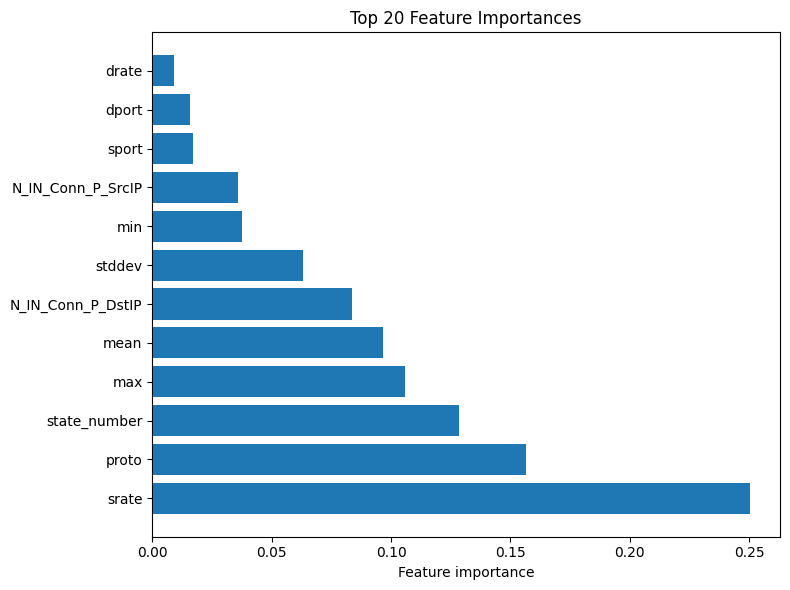

In [11]:
# feature importance
importances = best_model.feature_importances_
feat_names = X_train_full.columns.tolist()
idx_sorted = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8,6))
plt.barh(range(len(idx_sorted))[::-1], importances[idx_sorted][::-1])
plt.yticks(range(len(idx_sorted))[::-1], [feat_names[i] for i in idx_sorted][::-1])
plt.xlabel("Feature importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


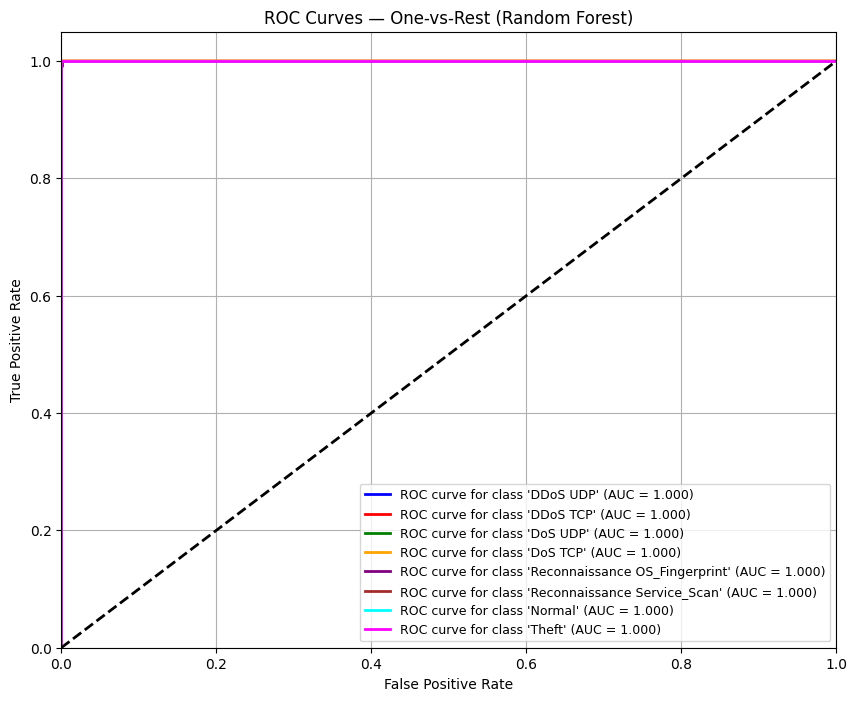

<Figure size 640x480 with 0 Axes>

In [12]:
# ROC Curves per class (One-vs-Rest)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Get class labels that appear in y_test
classes = np.unique(y_test)
class_names = [int_to_target[c] for c in classes]

# Binarize the output for OVR ROC
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probability scores (needed for ROC curves)
y_score = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta'])

for i, color in zip(range(len(classes)), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve for class '{class_names[i]}' (AUC = {roc_auc[i]:.3f})",
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest (Random Forest)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()
plt.savefig("roc_per_class.png", dpi=300)


In [13]:
# Measure training accuracy
train_pred = best_model.predict(X_train_full)
train_acc = accuracy_score(y_train_full, train_pred)

# Measure test accuracy
test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)

print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Difference:", train_acc - test_acc)


Training Accuracy: 0.9999775113746445
Test Accuracy: 0.9997233220436006
Difference: 0.00025418933104393027
